In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5), (0.5, ))]
                       )

# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST/train',
    train = True,
    download = True,
    transform = transform
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST/test',
    train = False,
    download = True,
    transform = transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/train/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/train/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/train/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/train/FashionMNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/test/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/test/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/test/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/test/FashionMNIST/raw



In [ ]:
train,valid = torch.utils.data.random_split(train_set, [50000,10000])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=128)
validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=128)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True,  batch_size = 128 )
i1, l1 = next(iter(trainloader))
print(i1.shape)

torch.Size([128, 1, 28, 28])


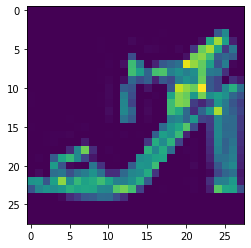

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(i1[0].squeeze(0))

In [3]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
    self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
    self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
    self.drop_out = nn.Dropout(0.5 )

    self.fc1 = nn.Linear(in_features=256, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = self.max_pool1(t)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = self.max_pool2(t)

    # conv 3
    t = self.conv3(t)
    t = self.drop_out(F.relu(t))
    #print(t.size())
    t = t.reshape(-1, 64*2*2)

    # fc1
    t = self.fc1(t)

    return t

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#train original data
model = Network()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001)
criterion = nn.CrossEntropyLoss()


In [ ]:
train_loss = []
val_loss = []
train_acc_list = []
val_acc_list = []
for e in range(15):
  epoch_train_loss = 0.0 
  epoch_val_loss = 0 
  train_acc = 0
  val_acc = 0
  for i, data in enumerate(trainloader):
        model.train()
        image = data[0].to(device)
        labels = data[1].to(device)
        # Zero the gradients.
        optimizer.zero_grad()
        # Feed forward
        output = model(image)
        preds = torch.argmax(output, axis=1)
        acc = torch.sum(preds == labels) / len(labels)
        # Calculate the batch loss.
        loss = criterion(output , labels)
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        epoch_train_loss += loss.item()
        train_acc += acc.item()

  model.eval()
  with torch.no_grad():
      for j, data in enumerate(validloader):
          
          image = data[0].to(device)
          labels = data[1].to(device)
          # Zero the gradients.
          optimizer.zero_grad()
          # Feed forward
          output = model(image)
          preds = torch.argmax(output, axis=1)
          v_acc = torch.sum(preds == labels) / len(labels)
          # Calculate the batch loss.
          loss = criterion(output , labels)
          epoch_val_loss += loss.item()
          val_acc += v_acc.item()

  print(f"epoch {e+1}  - loss train:  {epoch_train_loss/(i+1)} - loss vaidation: {epoch_val_loss/(j+1)} - train acc :  {train_acc/(i+1)} - val acc: {val_acc/(j+1)}")
  train_loss.append(epoch_train_loss/(i+1))
  val_loss.append(epoch_val_loss/(j+1))
  train_acc_list.append(train_acc/(i+1))
  val_acc_list.append(val_acc/(j+1))

epoch 1  - loss train:  0.6636474448091844 - loss vaidation: 0.3985548775784577 - train acc :  0.7590752878152501 - val acc: 0.8529469936708861
epoch 2  - loss train:  0.42868326150852704 - loss vaidation: 0.3484246625175959 - train acc :  0.846727141943734 - val acc: 0.8705498417721519
epoch 3  - loss train:  0.3943522468857143 - loss vaidation: 0.3341758175741268 - train acc :  0.8579283887163147 - val acc: 0.8806368670886076
epoch 4  - loss train:  0.36673733935026864 - loss vaidation: 0.3251154239796385 - train acc :  0.8666000639081306 - val acc: 0.8818235759493671
epoch 5  - loss train:  0.3498114942361022 - loss vaidation: 0.3306065448854543 - train acc :  0.873321611253197 - val acc: 0.8817246835443038
epoch 6  - loss train:  0.340782214041866 - loss vaidation: 0.29628038198887546 - train acc :  0.8755035167155059 - val acc: 0.8914161392405063
epoch 7  - loss train:  0.32360255480041283 - loss vaidation: 0.31116039032423043 - train acc :  0.8807544757033248 - val acc: 0.8847903

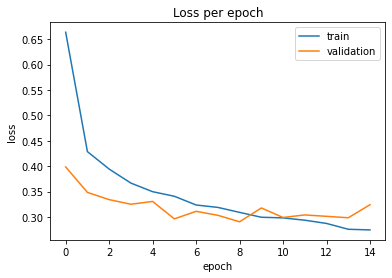

In [ ]:
plt.plot(train_loss, label = 'train')
plt.plot(val_loss,label='validation')
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

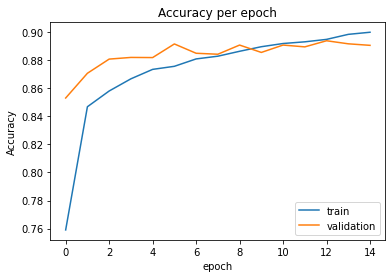

In [ ]:
plt.plot(train_acc_list, label = 'train')
plt.plot(val_acc_list,label='validation')
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  val_acc = 0
  for j, data in enumerate(testloader):
          
    image = data[0].to(device)
    labels = data[1].to(device)
    # Zero the gradients.
    optimizer.zero_grad()
    # Feed forward
    output = model(image)
    preds = torch.argmax(output, axis=1)
    v_acc = torch.sum(preds == labels) / len(labels)
    # Calculate the batch loss.
    loss = criterion(output , labels)
    epoch_val_loss += loss.item()
    val_acc += v_acc.item()
  print('Test Accuracy: ', val_acc/(j+1))


Test Accuracy:  0.8836036392405063


# Gossip Training

## Effect of different P values

In [5]:
def p2p_aggregate(first_model, second_model, first_weight, second_weight):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = first_model.state_dict()
    for k in global_dict.keys():
      first = first_model.state_dict()[k] * (first_weight) / (first_weight + second_weight)
      second = second_model.state_dict()[k] * (second_weight) / (first_weight + second_weight)
      sum_2 = first.add(second)
      global_dict[k] =  sum_2
    first_model.load_state_dict(global_dict)
    #second_model.load_state_dict(global_dict)

In [6]:
def client_update(model, optimizer, data):
    """
    This function updates/trains client model on client data
    """
    model.train()
    image = data[0].to(device)
    labels = data[1].to(device)
    # Zero the gradients.
    optimizer.zero_grad()
    # Feed forward
    output = model(image)
    preds = torch.argmax(output, axis=1)
    acc = torch.sum(preds == labels) / len(labels)
    # Calculate the batch loss.
    loss = criterion(output , labels)
    # Backward pass.
    loss.backward()

    # Update the parameters in the optimizer.
    optimizer.step()
      
    return loss.item() , acc.item()

In [7]:
def validation(client_models, validation_loader):
  """This function test the global model on test data and returns test loss and test accuracy """
  losses = []
  accs = []
  for i in range(len(client_models)):
    model = client_models[i]
    model.eval()
    epoch_val_loss = 0
    val_acc= 0 
    with torch.no_grad():
        for j, data in enumerate(validloader): 
          image = data[0].to(device)
          labels = data[1].to(device)
          # Feed forward
          output = model(image)
          preds = torch.argmax(output, axis=1)
          v_acc = torch.sum(preds == labels) / len(labels)
          # Calculate the batch loss.
          loss = criterion(output , labels)
          epoch_val_loss += loss.item()
          val_acc += v_acc.item()
    accs.append(val_acc/j)
    losses.append(epoch_val_loss/j)
  return np.mean(losses),  np.mean(accs)

In [8]:
def second_agent(agent_i, weights):
  agents = [i for i in range(num_clients)]
  agents.remove(agent_i)
  second_agent = np.random.choice(a = agents  , p=[1/(num_clients-1) for i in range(num_clients-1)])
  return second_agent


In [9]:
def process_messages( queue, reciver):
  
  for sender in queue.keys():
    weight_i = communication_matrix[reciver][reciver]
    weight_j = communication_matrix[reciver][queue[sender]]
    p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j)
    communication_matrix[reciver][reciver] += weight_j
    
  

In [10]:
def push_message(sender, reciver):
  communication_matrix[reciver][sender] /= 2
  queue[reciver][str(sender)] = sender

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


### P = 0.5

In [12]:
batch_size = 128
num_clients = 5

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train = []
acc_train = []
val_losses = []
val_accs = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train.append(loss/num_clients)
        acc_train.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train[-1]} - average train accuracy {acc_train[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.8959614157676696 - average train accuracy 0.6625 - epoch validation loss 0.8091411554660553 - epoch validation accuracy 0.7215144230769232


100%|██████████| 79/79 [00:23<00:00,  3.29it/s]


average train loss 0.6074466943740845 - average train accuracy 0.7875 - epoch validation loss 0.5712101080860847 - epoch validation accuracy 0.7948517628205127


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


average train loss 0.7359985470771789 - average train accuracy 0.7 - epoch validation loss 0.5213662448219764 - epoch validation accuracy 0.8261217948717949


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.3942922353744507 - average train accuracy 0.8 - epoch validation loss 0.4877189239248252 - epoch validation accuracy 0.8349759615384615


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.25145151615142824 - average train accuracy 0.9125 - epoch validation loss 0.4513100167879691 - epoch validation accuracy 0.8467948717948719


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.3529848277568817 - average train accuracy 0.8875 - epoch validation loss 0.42222997053311423 - epoch validation accuracy 0.858633814102564


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.37836599349975586 - average train accuracy 0.8375 - epoch validation loss 0.42416929487998667 - epoch validation accuracy 0.8612580128205127


100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


average train loss 0.4337861716747284 - average train accuracy 0.875 - epoch validation loss 0.4183298375362005 - epoch validation accuracy 0.8604366987179487


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.4341356486082077 - average train accuracy 0.8375 - epoch validation loss 0.40993080903322265 - epoch validation accuracy 0.8659054487179487


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.4545027524232864 - average train accuracy 0.8875 - epoch validation loss 0.40241608315935506 - epoch validation accuracy 0.8708133012820513


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.3614533215761185 - average train accuracy 0.9 - epoch validation loss 0.3983446645431029 - epoch validation accuracy 0.8700120192307692


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.18827082067728043 - average train accuracy 0.95 - epoch validation loss 0.40013082323548127 - epoch validation accuracy 0.8741386217948719


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.30762489289045336 - average train accuracy 0.8875 - epoch validation loss 0.40834170526418934 - epoch validation accuracy 0.8709735576923077


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.21359168291091918 - average train accuracy 0.925 - epoch validation loss 0.4128208593680308 - epoch validation accuracy 0.8732972756410255


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


average train loss 0.24210514426231383 - average train accuracy 0.875 - epoch validation loss 0.3931380445758502 - epoch validation accuracy 0.8764022435897436


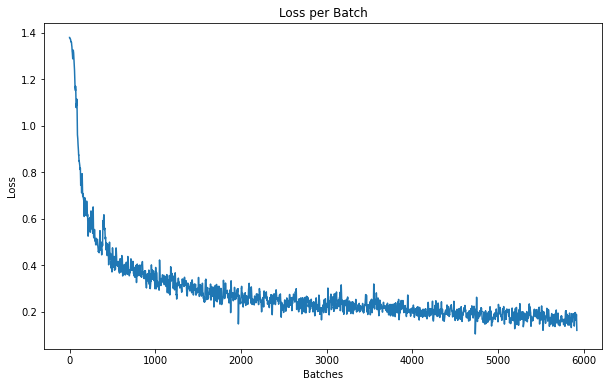

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

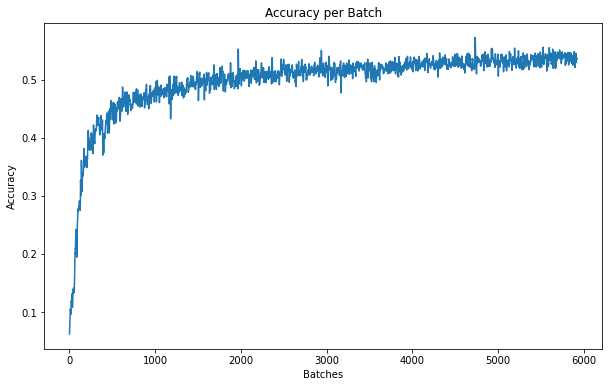

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

#### Test

In [ ]:
model_test_acc = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc))

average Test Accuracy:  0.8729967948717949


### p = 1

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_p1 = []
acc_train_p1 = []
val_losses_p1 = []
val_accs_p1 = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 1):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_p1.append(loss/num_clients)
        acc_train_p1.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_p1.append(val_accuracy)
    val_losses_p1.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_p1[-1]} - average train accuracy {acc_train_p1[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.6575050771236419 - average train accuracy 0.7625 - epoch validation loss 0.8105311486965571 - epoch validation accuracy 0.7286658653846153


100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


average train loss 0.7156328618526459 - average train accuracy 0.7875 - epoch validation loss 0.5550215443739523 - epoch validation accuracy 0.8023437499999998


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.5058090031147003 - average train accuracy 0.8 - epoch validation loss 0.532717500703457 - epoch validation accuracy 0.8242788461538462


100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


average train loss 0.39927162826061247 - average train accuracy 0.8625 - epoch validation loss 0.45096215536961193 - epoch validation accuracy 0.8492988782051283


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.40717590153217315 - average train accuracy 0.8625 - epoch validation loss 0.4388029468747286 - epoch validation accuracy 0.8541866987179487


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


average train loss 0.6283482193946839 - average train accuracy 0.775 - epoch validation loss 0.4648898685589815 - epoch validation accuracy 0.8484575320512822


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


average train loss 0.3272154301404953 - average train accuracy 0.8625 - epoch validation loss 0.39102981247198887 - epoch validation accuracy 0.8674879807692306


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.3905060052871704 - average train accuracy 0.825 - epoch validation loss 0.3939443065952032 - epoch validation accuracy 0.8726762820512821


100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


average train loss 0.29926354736089705 - average train accuracy 0.8875 - epoch validation loss 0.41229323916710336 - epoch validation accuracy 0.8635016025641026


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.4806233048439026 - average train accuracy 0.8375 - epoch validation loss 0.39196121646807747 - epoch validation accuracy 0.8748998397435898


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.22922728657722474 - average train accuracy 0.9375 - epoch validation loss 0.43761001888376005 - epoch validation accuracy 0.8641826923076923


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.5128678798675537 - average train accuracy 0.8125 - epoch validation loss 0.40619459734895297 - epoch validation accuracy 0.8701522435897436


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.23641913682222365 - average train accuracy 0.9 - epoch validation loss 0.4014049392480117 - epoch validation accuracy 0.8744791666666668


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.29886609464883807 - average train accuracy 0.9 - epoch validation loss 0.41796566733183005 - epoch validation accuracy 0.8755008012820513


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.31699844300746916 - average train accuracy 0.8875 - epoch validation loss 0.3979884442419578 - epoch validation accuracy 0.8802684294871795


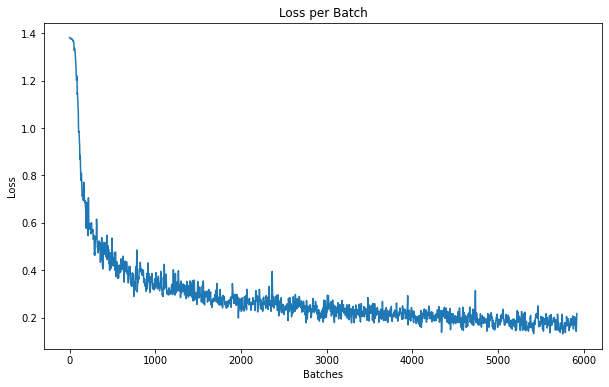

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_p1 , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

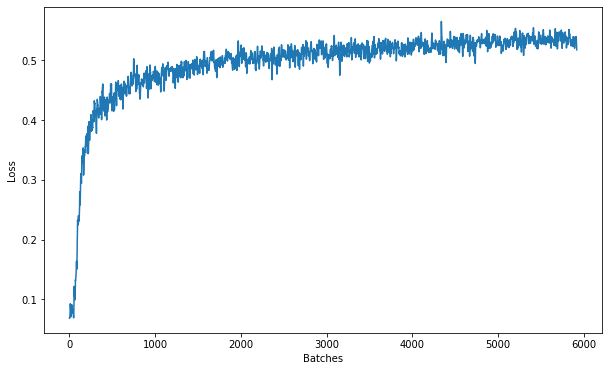

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_p1 , np.ones(5)/5, mode='valid'))
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

#### Test

In [ ]:
model_test_acc_p1 = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_p1.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_p1))

average Test Accuracy:  0.871474358974359


### P = 0.01

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_p001 = []
acc_train_p001 = []
val_losses_p001 = []
val_accs_p001 = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.01):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_p001.append(loss/num_clients)
        acc_train_p001.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_p001.append(val_accuracy)
    val_losses_p001.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_p001[-1]} - average train accuracy {acc_train_p001[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


average train loss 0.6020940721035004 - average train accuracy 0.8125 - epoch validation loss 0.665489054337526 - epoch validation accuracy 0.7592748397435898


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


average train loss 0.5705834746360778 - average train accuracy 0.7875 - epoch validation loss 0.5338601142932207 - epoch validation accuracy 0.814523237179487


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


average train loss 0.5132610678672791 - average train accuracy 0.8375 - epoch validation loss 0.4770723336782211 - epoch validation accuracy 0.8356169871794872


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


average train loss 0.5519414663314819 - average train accuracy 0.7875 - epoch validation loss 0.4826473220418661 - epoch validation accuracy 0.8328125


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


average train loss 0.39887251853942873 - average train accuracy 0.925 - epoch validation loss 0.43728679342147625 - epoch validation accuracy 0.8563301282051283


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


average train loss 0.5903374403715134 - average train accuracy 0.7875 - epoch validation loss 0.4016596980201893 - epoch validation accuracy 0.8690705128205127


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


average train loss 0.4602477878332138 - average train accuracy 0.825 - epoch validation loss 0.40582514577187023 - epoch validation accuracy 0.8673677884615385


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


average train loss 0.37285477519035337 - average train accuracy 0.875 - epoch validation loss 0.39192155664547895 - epoch validation accuracy 0.8679487179487179


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


average train loss 0.5066825121641159 - average train accuracy 0.8125 - epoch validation loss 0.37926252984847775 - epoch validation accuracy 0.8761017628205128


100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


average train loss 0.3397836804389954 - average train accuracy 0.85 - epoch validation loss 0.3919035772482554 - epoch validation accuracy 0.8717347756410255


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


average train loss 0.3840547055006027 - average train accuracy 0.85 - epoch validation loss 0.3887137545798069 - epoch validation accuracy 0.871554487179487


100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


average train loss 0.35885603725910187 - average train accuracy 0.8625 - epoch validation loss 0.39040002184800615 - epoch validation accuracy 0.8749599358974358


100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


average train loss 0.2783012479543686 - average train accuracy 0.8875 - epoch validation loss 0.3913004560634876 - epoch validation accuracy 0.8783453525641025


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


average train loss 0.3137634977698326 - average train accuracy 0.875 - epoch validation loss 0.41016018845331975 - epoch validation accuracy 0.8739783653846154


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.26862514168024065 - average train accuracy 0.9 - epoch validation loss 0.39386181399608267 - epoch validation accuracy 0.8728365384615385


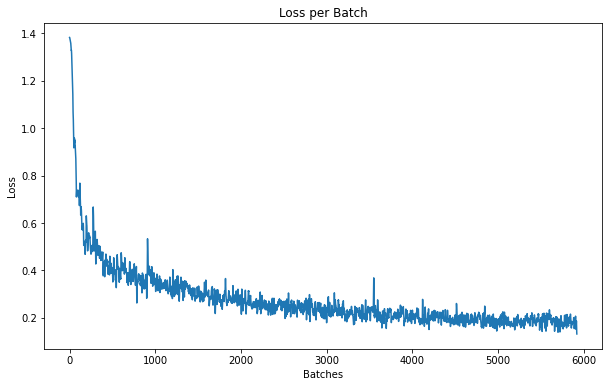

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_p001 , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

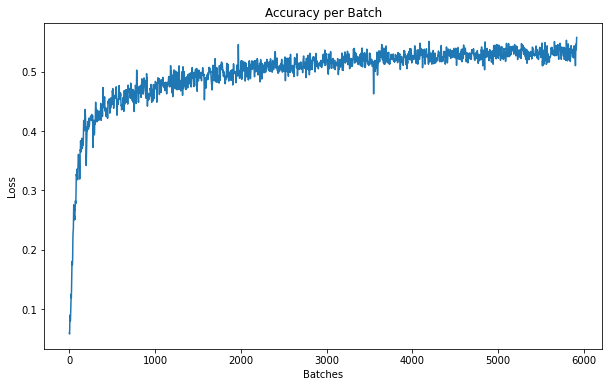

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_p001 , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

#### Test

In [ ]:
model_test_acc_p001 = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_p001.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_p001))

average Test Accuracy:  0.8645232371794872


### P = 0.2

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_p01 = []
acc_train_p01 = []
val_losses_p01 = []
val_accs_p01 = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.2):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_p01.append(loss/num_clients)
        acc_train_p01.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_p01.append(val_accuracy)
    val_losses_p01.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_p01[-1]} - average train accuracy {acc_train_p01[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.6047433495521546 - average train accuracy 0.8 - epoch validation loss 0.6831316783642157 - epoch validation accuracy 0.7522235576923076


100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


average train loss 0.8384345233440399 - average train accuracy 0.7375 - epoch validation loss 0.5757154278266124 - epoch validation accuracy 0.7997996794871796


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.42814951837062837 - average train accuracy 0.8375 - epoch validation loss 0.4810526354954793 - epoch validation accuracy 0.8366386217948719


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.38700725734233854 - average train accuracy 0.8875 - epoch validation loss 0.4558736226497552 - epoch validation accuracy 0.8494391025641026


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.5038898378610611 - average train accuracy 0.85 - epoch validation loss 0.42029002736776305 - epoch validation accuracy 0.8601963141025643


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.47871127128601076 - average train accuracy 0.8125 - epoch validation loss 0.4065418664843608 - epoch validation accuracy 0.8637219551282052


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


average train loss 0.3329061597585678 - average train accuracy 0.875 - epoch validation loss 0.4035147555363484 - epoch validation accuracy 0.8696714743589743


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.3555597960948944 - average train accuracy 0.9375 - epoch validation loss 0.4019330471754074 - epoch validation accuracy 0.8692708333333334


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.39343003630638124 - average train accuracy 0.85 - epoch validation loss 0.3882867735929979 - epoch validation accuracy 0.8780448717948719


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.29330624341964723 - average train accuracy 0.875 - epoch validation loss 0.40907104328656807 - epoch validation accuracy 0.8676282051282052


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.31335803866386414 - average train accuracy 0.875 - epoch validation loss 0.3870837794091457 - epoch validation accuracy 0.8771834935897436


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.41799461245536806 - average train accuracy 0.8625 - epoch validation loss 0.38870232842671565 - epoch validation accuracy 0.8755608974358975


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.2814213827252388 - average train accuracy 0.9 - epoch validation loss 0.39308540404607084 - epoch validation accuracy 0.8792067307692306


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.26758892089128494 - average train accuracy 0.9 - epoch validation loss 0.3851904436372794 - epoch validation accuracy 0.8819110576923077


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.22319628447294235 - average train accuracy 0.9375 - epoch validation loss 0.41471645837792986 - epoch validation accuracy 0.8811298076923076


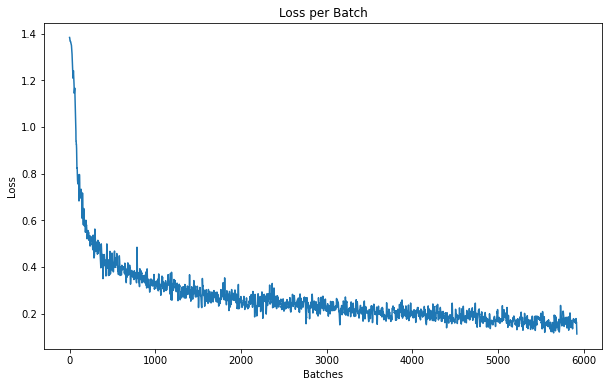

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_p01 , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

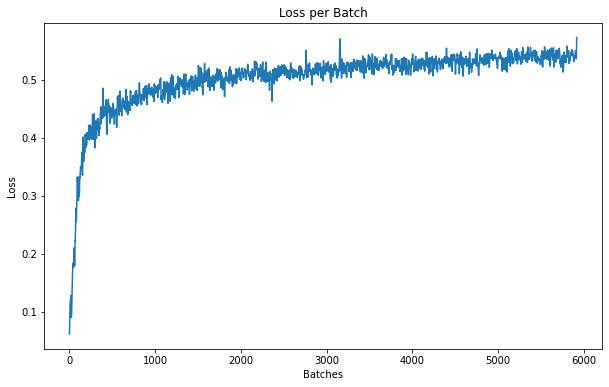

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_p01 , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

#### Test

In [ ]:
model_test_acc_p01 = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_p01.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_p01))

average Test Accuracy:  0.8725961538461539


### Comparison

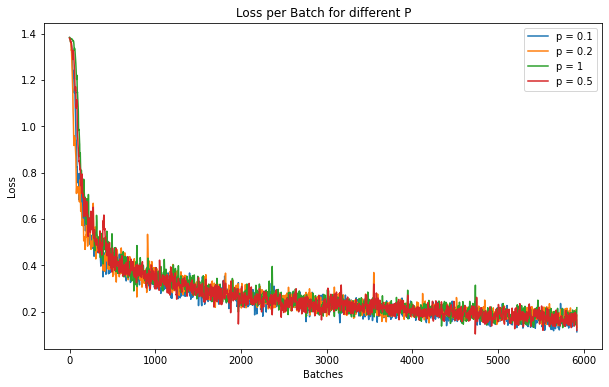

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_p01 , np.ones(5)/5, mode='valid'), label='p = 0.1')
plt.plot(np.convolve(losses_train_p001 , np.ones(5)/5, mode='valid'), label='p = 0.2')
plt.plot(np.convolve(losses_train_p1 , np.ones(5)/5, mode='valid'), label='p = 1')
plt.plot(np.convolve(losses_train , np.ones(5)/5, mode='valid'), label='p = 0.5')
plt.title('Loss per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

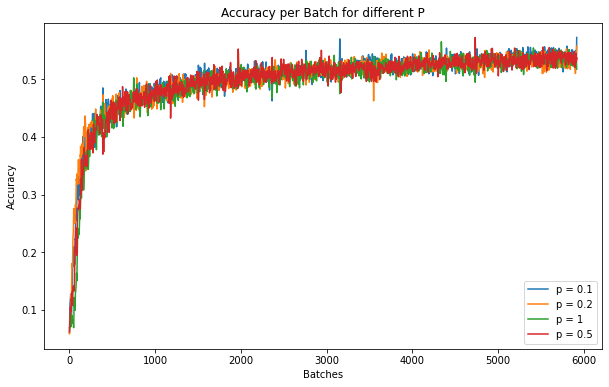

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_p01 , np.ones(5)/5, mode='valid'), label='p = 0.1')
plt.plot(np.convolve(acc_train_p001 , np.ones(5)/5, mode='valid'), label='p = 0.2')
plt.plot(np.convolve(acc_train_p1 , np.ones(5)/5, mode='valid'), label='p = 1')
plt.plot(np.convolve(acc_train , np.ones(5)/5, mode='valid'), label='p = 0.5')
plt.title('Accuracy per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Effect of Periodically strongly connected and Strongly connected

### Periodically connected

In [50]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [51]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [52]:
def push_message(sender, reciver):
  #communication_matrix[reciver][sender] /= 2
  queue[reciver][str(sender)] = sender

In [53]:
def process_messages( queue, reciver):
  
  for sender in queue.keys():
    weight_i = communication_matrix[reciver][reciver]
    weight_j = communication_matrix[reciver][queue[sender]]
    p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j)
    #communication_matrix[reciver][reciver] += weight_j
    
  

In [54]:
matrix_one = np.array([[1,1,0,0,0],[0,1,1,0,0],[0,0,1,1,0],[0,0,0,1,1],[0,0,1,0,1]])
matrix_two = np.array([[1,0,1,0,0],[1,1,0,0,0],[0,1,1,0,0],[1,0,0,1,0],[0,1,0,0,1]])
matrix_three = np.array([[1,0,0,1,0],[0,1,0,1,0],[1,0,1,0,0],[0,1,0,1,0],[1,0,0,0,1]])
matrix_four = np.array([[1,0,0,0,1],[0,1,0,0,1],[0,0,1,0,1],[0,0,1,1,0],[0,0,0,1,1]])

In [55]:
matrixes = [matrix_one, matrix_two, matrix_three, matrix_four]

In [56]:
criterion = nn.CrossEntropyLoss()

In [57]:
losses_train_per = []
acc_train_per = []
val_losses_per = []
val_accs_per = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      communication_matrix = matrixes[j%4]
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.2):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_per.append(loss/num_clients)
        acc_train_per.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_per.append(val_accuracy)
    val_losses_per.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_per[-1]} - average train accuracy {acc_train_per[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.7719739437103271 - average train accuracy 0.7 - epoch validation loss 0.7048836849438839 - epoch validation accuracy 0.7489783653846154


100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


average train loss 0.5078488945960998 - average train accuracy 0.7875 - epoch validation loss 0.5581245677593427 - epoch validation accuracy 0.8027644230769232


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.5379264384508133 - average train accuracy 0.825 - epoch validation loss 0.4743496251411927 - epoch validation accuracy 0.8386217948717949


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.41749845147132875 - average train accuracy 0.8375 - epoch validation loss 0.4483985842038424 - epoch validation accuracy 0.8490184294871795


100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


average train loss 0.3681796282529831 - average train accuracy 0.85 - epoch validation loss 0.39981058641121936 - epoch validation accuracy 0.8679086538461538


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.5271305561065673 - average train accuracy 0.825 - epoch validation loss 0.3870222635376148 - epoch validation accuracy 0.8702123397435898


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.5011389195919037 - average train accuracy 0.85 - epoch validation loss 0.38333697724036686 - epoch validation accuracy 0.871554487179487


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.26414753347635267 - average train accuracy 0.9125 - epoch validation loss 0.36733470391004514 - epoch validation accuracy 0.8802083333333334


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.4580537140369415 - average train accuracy 0.8 - epoch validation loss 0.34850939412911736 - epoch validation accuracy 0.8876602564102564


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.26818874664604664 - average train accuracy 0.9 - epoch validation loss 0.3388474791095807 - epoch validation accuracy 0.8908052884615385


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.3160823009908199 - average train accuracy 0.9125 - epoch validation loss 0.3333557212964083 - epoch validation accuracy 0.8929086538461538


100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


average train loss 0.24878057539463044 - average train accuracy 0.875 - epoch validation loss 0.32846279865465106 - epoch validation accuracy 0.8927684294871794


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.2866346210241318 - average train accuracy 0.875 - epoch validation loss 0.3228867267186825 - epoch validation accuracy 0.8966346153846153


100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


average train loss 0.3578890174627304 - average train accuracy 0.875 - epoch validation loss 0.3262700599928697 - epoch validation accuracy 0.8951722756410257


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.3557212471961975 - average train accuracy 0.8625 - epoch validation loss 0.3186777654748697 - epoch validation accuracy 0.8982572115384617


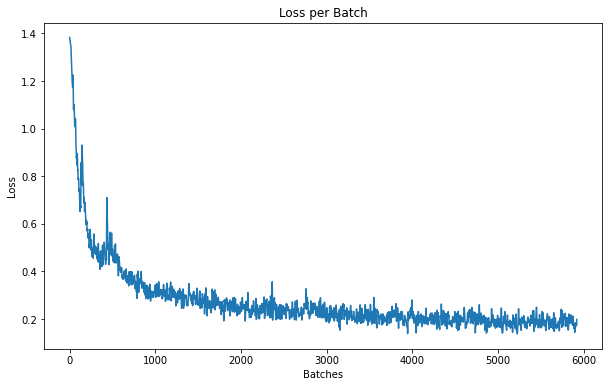

In [58]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_per , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

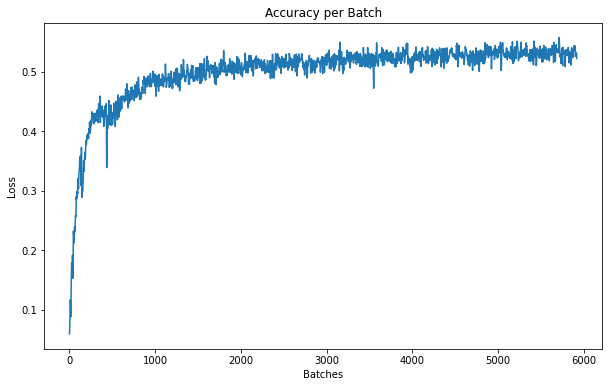

In [59]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_per , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

In [60]:
model_test_acc_per = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_per.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_per))

average Test Accuracy:  0.8918870192307692


### Strongly Connected

In [61]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [62]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

In [63]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [64]:
losses_train_stg = []
acc_train_stg = []
val_losses_stg = []
val_accs_stg = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.2):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_stg.append(loss/num_clients)
        acc_train_stg.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_stg.append(val_accuracy)
    val_losses_stg.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_stg[-1]} - average train accuracy {acc_train_stg[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


average train loss 0.7788326025009156 - average train accuracy 0.675 - epoch validation loss 0.6436652751305164 - epoch validation accuracy 0.7685496794871793


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.45052801370620726 - average train accuracy 0.8625 - epoch validation loss 0.5100766826898624 - epoch validation accuracy 0.8228365384615385


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.5105108827352524 - average train accuracy 0.8 - epoch validation loss 0.42573497408093547 - epoch validation accuracy 0.8578125


100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


average train loss 0.3652974084019661 - average train accuracy 0.8125 - epoch validation loss 0.39992370914954406 - epoch validation accuracy 0.8658453525641026


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.4927796900272369 - average train accuracy 0.825 - epoch validation loss 0.4042038581692256 - epoch validation accuracy 0.8682291666666666


100%|██████████| 79/79 [00:30<00:00,  2.59it/s]


average train loss 0.5397467195987702 - average train accuracy 0.85 - epoch validation loss 0.3639076281816531 - epoch validation accuracy 0.8774238782051281


100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


average train loss 0.2863729581236839 - average train accuracy 0.875 - epoch validation loss 0.3211260724908266 - epoch validation accuracy 0.8967347756410255


100%|██████████| 79/79 [00:24<00:00,  3.27it/s]


average train loss 0.32077842950820923 - average train accuracy 0.85 - epoch validation loss 0.3277413432987837 - epoch validation accuracy 0.890604967948718


100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


average train loss 0.20518613308668138 - average train accuracy 0.9 - epoch validation loss 0.3076386455924083 - epoch validation accuracy 0.9005008012820512


100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


average train loss 0.29464477896690366 - average train accuracy 0.875 - epoch validation loss 0.31664148208040455 - epoch validation accuracy 0.8992588141025643


100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


average train loss 0.4516461670398712 - average train accuracy 0.775 - epoch validation loss 0.3128859597711991 - epoch validation accuracy 0.899979967948718


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.27468904554843904 - average train accuracy 0.8875 - epoch validation loss 0.3053532035878071 - epoch validation accuracy 0.901923076923077


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


average train loss 0.34868651181459426 - average train accuracy 0.875 - epoch validation loss 0.3023786940444738 - epoch validation accuracy 0.9055088141025642


100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.23471627235412598 - average train accuracy 0.875 - epoch validation loss 0.32213899319370587 - epoch validation accuracy 0.8950120192307691


100%|██████████| 79/79 [00:22<00:00,  3.59it/s]


average train loss 0.16935347551479935 - average train accuracy 0.9125 - epoch validation loss 0.2954808847835431 - epoch validation accuracy 0.9082932692307694


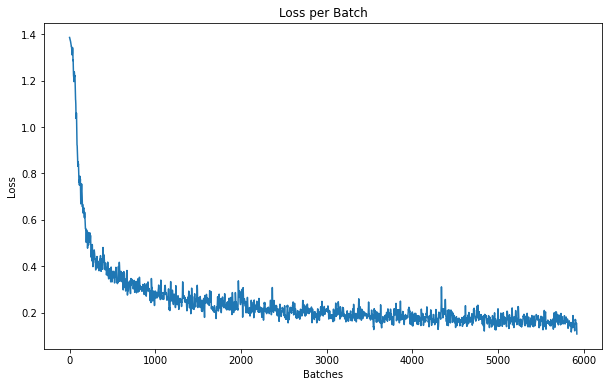

In [65]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_stg , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

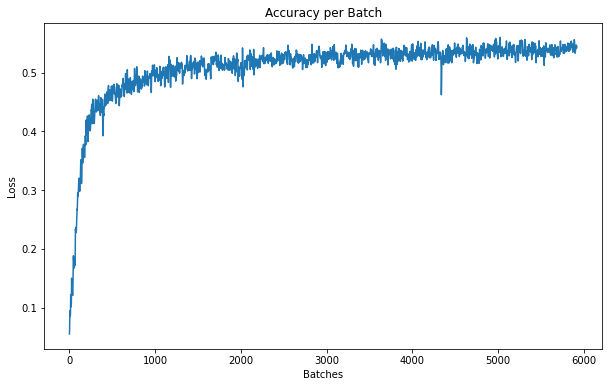

In [66]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_stg , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [67]:
model_test_acc_stg = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_stg.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_stg))

average Test Accuracy:  0.8981770833333332


### Comparison

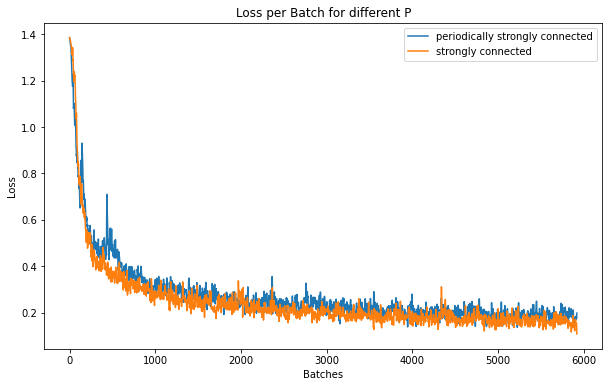

In [68]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_per , np.ones(5)/5, mode='valid'), label='periodically strongly connected')
plt.plot(np.convolve(losses_train_stg , np.ones(5)/5, mode='valid'), label='strongly connected')
plt.title('Loss per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

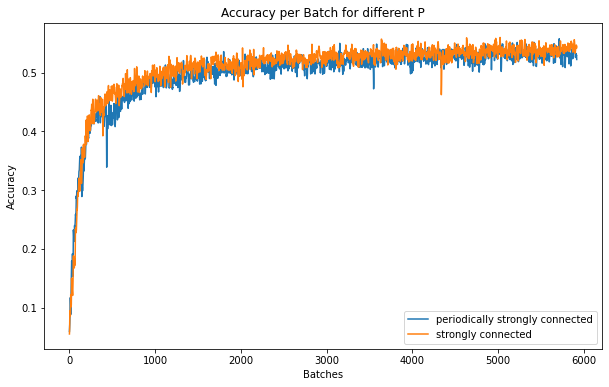

In [69]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_per , np.ones(5)/5, mode='valid'), label='periodically strongly connected')
plt.plot(np.convolve(acc_train_stg , np.ones(5)/5, mode='valid'), label='strongly connected')
plt.title('Accuracy per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Effect of Different Communication matrixes

In [ ]:
def process_messages( queue, reciver, constant = False):
  
  for sender in queue.keys():
    weight_i = communication_matrix[reciver][reciver]
    weight_j = communication_matrix[reciver][queue[sender]]
    p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j)
    if not constant:
      communication_matrix[reciver][reciver] += weight_j
    
  

In [ ]:
def push_message(sender, reciver, constant=False):
  if not constant:
    communication_matrix[reciver][sender] /= 2
  queue[reciver][str(sender)] = sender

In [ ]:
batch_size = 128
num_clients = 5

### Double Random (constant)

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

criterion = nn.CrossEntropyLoss()

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train = []
acc_train = []
val_losses = []
val_accs = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i, True)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i, True)
        except StopIteration:
          pass
        losses_train.append(loss/num_clients)
        acc_train.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train[-1]} - average train accuracy {acc_train[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


average train loss 0.511961704492569 - average train accuracy 0.775 - epoch validation loss 0.6476089414113607 - epoch validation accuracy 0.766806891025641


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.4469573676586151 - average train accuracy 0.825 - epoch validation loss 0.46449809678089926 - epoch validation accuracy 0.8396634615384615


100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


average train loss 0.35438844561576843 - average train accuracy 0.85 - epoch validation loss 0.43024819042438117 - epoch validation accuracy 0.8543870192307692


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.30089405477046965 - average train accuracy 0.925 - epoch validation loss 0.38737060668376777 - epoch validation accuracy 0.8706330128205128


100%|██████████| 79/79 [00:20<00:00,  3.76it/s]


average train loss 0.22064724564552307 - average train accuracy 0.95 - epoch validation loss 0.36472750539198906 - epoch validation accuracy 0.8810496794871796


100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


average train loss 0.32457045316696165 - average train accuracy 0.825 - epoch validation loss 0.3203000616950866 - epoch validation accuracy 0.8970552884615385


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


average train loss 0.21051223576068878 - average train accuracy 0.9125 - epoch validation loss 0.34904163091992724 - epoch validation accuracy 0.8875801282051281


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.2549149602651596 - average train accuracy 0.8875 - epoch validation loss 0.3341543011940443 - epoch validation accuracy 0.8871594551282052


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.2583534047007561 - average train accuracy 0.9 - epoch validation loss 0.2990495290893775 - epoch validation accuracy 0.9053685897435898


100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


average train loss 0.3125504903495312 - average train accuracy 0.9 - epoch validation loss 0.3240465460213809 - epoch validation accuracy 0.8952123397435898


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.281325127184391 - average train accuracy 0.85 - epoch validation loss 0.31185985306898756 - epoch validation accuracy 0.8995993589743592


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.14402233585715293 - average train accuracy 0.9625 - epoch validation loss 0.28909123324048824 - epoch validation accuracy 0.907792467948718


100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


average train loss 0.26130136027932166 - average train accuracy 0.925 - epoch validation loss 0.30683223897447953 - epoch validation accuracy 0.9016626602564102


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.31737259328365325 - average train accuracy 0.875 - epoch validation loss 0.2987941419084867 - epoch validation accuracy 0.9071514423076923


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.2389744222164154 - average train accuracy 0.925 - epoch validation loss 0.287594684270712 - epoch validation accuracy 0.907431891025641


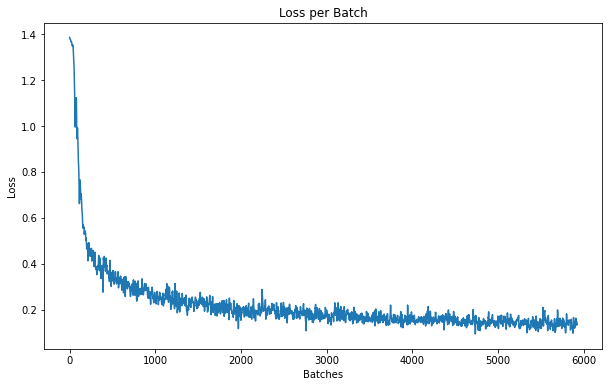

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

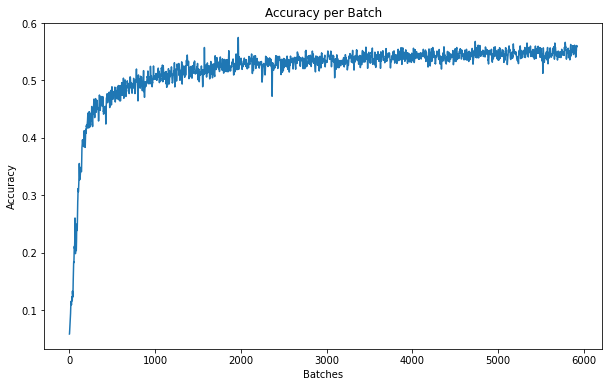

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model_test_acc = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc))

average Test Accuracy:  0.9056690705128204


### Random (constant)

In [ ]:
communication_matrix = np.random.randint(0, 20, size = (num_clients,num_clients))  
communication_matrix = communication_matrix / communication_matrix.sum(1, keepdims=True)

In [ ]:
communication_matrix

array([[0.40625   , 0.53125   , 0.        , 0.        , 0.0625    ],
       [0.25      , 0.25      , 0.21052632, 0.09210526, 0.19736842],
       [0.14925373, 0.14925373, 0.23880597, 0.17910448, 0.28358209],
       [0.19607843, 0.17647059, 0.21568627, 0.31372549, 0.09803922],
       [0.3       , 0.175     , 0.15      , 0.15      , 0.225     ]])

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

criterion = nn.CrossEntropyLoss()

In [ ]:
losses_train_random = []
acc_train_random = []
val_losses_random = []
val_accs_random = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i, True)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i, True)
        except StopIteration:
          pass
        losses_train_random.append(loss/num_clients)
        acc_train_random.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_random.append(val_accuracy)
    val_losses_random.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_random[-1]} - average train accuracy {acc_train_random[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


average train loss 0.45436726212501527 - average train accuracy 0.8875 - epoch validation loss 0.5953440113709524 - epoch validation accuracy 0.7849358974358974


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.4713822156190872 - average train accuracy 0.8375 - epoch validation loss 0.456993438456303 - epoch validation accuracy 0.8405248397435898


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.5572067320346832 - average train accuracy 0.8 - epoch validation loss 0.4121481488530453 - epoch validation accuracy 0.8607371794871795


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.3518307596445084 - average train accuracy 0.875 - epoch validation loss 0.37135900551309947 - epoch validation accuracy 0.8745192307692307


100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


average train loss 0.40256455540657043 - average train accuracy 0.875 - epoch validation loss 0.3583254315532171 - epoch validation accuracy 0.8793669871794872


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.45554159879684447 - average train accuracy 0.8625 - epoch validation loss 0.3346126521245027 - epoch validation accuracy 0.8857371794871796


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


average train loss 0.22931667566299438 - average train accuracy 0.925 - epoch validation loss 0.30997531947035056 - epoch validation accuracy 0.8957532051282051


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.3011900335550308 - average train accuracy 0.875 - epoch validation loss 0.31955096404521893 - epoch validation accuracy 0.8934094551282051


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.28416536152362826 - average train accuracy 0.9 - epoch validation loss 0.3096391109319834 - epoch validation accuracy 0.8979767628205128


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.20228675603866578 - average train accuracy 0.9375 - epoch validation loss 0.2987785729460227 - epoch validation accuracy 0.8996594551282051


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.26409642994403837 - average train accuracy 0.9 - epoch validation loss 0.29593909856600636 - epoch validation accuracy 0.9039463141025641


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.22721026837825775 - average train accuracy 0.925 - epoch validation loss 0.28942269891118394 - epoch validation accuracy 0.905068108974359


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.13426996804773808 - average train accuracy 0.9375 - epoch validation loss 0.2907192435020055 - epoch validation accuracy 0.9061097756410256


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.21084521412849427 - average train accuracy 0.8875 - epoch validation loss 0.272409348992201 - epoch validation accuracy 0.9108974358974358


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.40488347187638285 - average train accuracy 0.8625 - epoch validation loss 0.2738933187264662 - epoch validation accuracy 0.9105568910256411


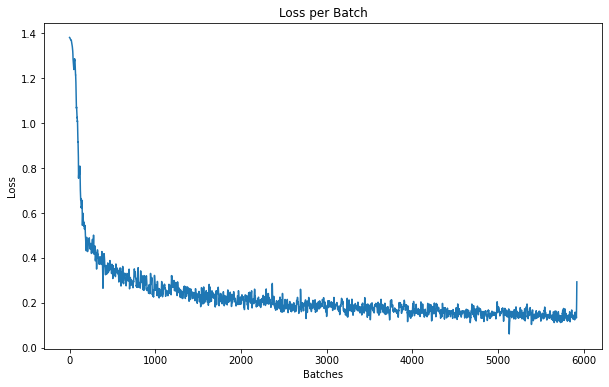

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_random , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

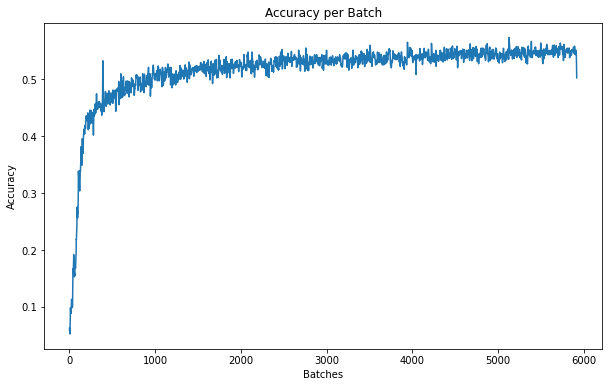

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_random , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model_test_acc_random = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_random.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_random))

average Test Accuracy:  0.9098357371794872


### Variation with time

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

criterion = nn.CrossEntropyLoss()

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_time = []
acc_train_time = []
val_losses_time = []
val_accs_time = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i, False)
          queue[i] = {}
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i, False)
        except StopIteration:
          pass
        losses_train_time.append(loss/num_clients)
        acc_train_time.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_time.append(val_accuracy)
    val_losses_time.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_time[-1]} - average train accuracy {acc_train_time[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.632305920124054 - average train accuracy 0.7375 - epoch validation loss 0.6658435557897274 - epoch validation accuracy 0.7546875


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


average train loss 0.6110164374113083 - average train accuracy 0.8 - epoch validation loss 0.5267795822559258 - epoch validation accuracy 0.8136217948717949


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


average train loss 0.5200428903102875 - average train accuracy 0.775 - epoch validation loss 0.4976349886411275 - epoch validation accuracy 0.8319511217948717


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.37493033707141876 - average train accuracy 0.8125 - epoch validation loss 0.4438262790059433 - epoch validation accuracy 0.8497996794871796


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.5878176927566529 - average train accuracy 0.8 - epoch validation loss 0.4366674180787343 - epoch validation accuracy 0.8548878205128206


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.5346698969602585 - average train accuracy 0.8125 - epoch validation loss 0.4067524566100194 - epoch validation accuracy 0.8678685897435898


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.3964597940444946 - average train accuracy 0.8125 - epoch validation loss 0.3870813601674178 - epoch validation accuracy 0.8735977564102564


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.3201848953962326 - average train accuracy 0.9125 - epoch validation loss 0.4077485426878318 - epoch validation accuracy 0.8667067307692307


100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


average train loss 0.1836954265832901 - average train accuracy 0.9375 - epoch validation loss 0.3826165742216966 - epoch validation accuracy 0.8763621794871795


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


average train loss 0.3097545862197876 - average train accuracy 0.9125 - epoch validation loss 0.37986149056217605 - epoch validation accuracy 0.8785657051282053


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.3701075047254562 - average train accuracy 0.8625 - epoch validation loss 0.3844867071471153 - epoch validation accuracy 0.8787660256410256


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.532702112197876 - average train accuracy 0.7875 - epoch validation loss 0.3947388015114345 - epoch validation accuracy 0.8728165064102565


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.24127256870269775 - average train accuracy 0.9 - epoch validation loss 0.3812075683130668 - epoch validation accuracy 0.8780649038461539


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.5770934700965882 - average train accuracy 0.825 - epoch validation loss 0.39288274428019154 - epoch validation accuracy 0.8809294871794873


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


average train loss 0.34482707753777503 - average train accuracy 0.875 - epoch validation loss 0.40527637042105197 - epoch validation accuracy 0.8769431089743589


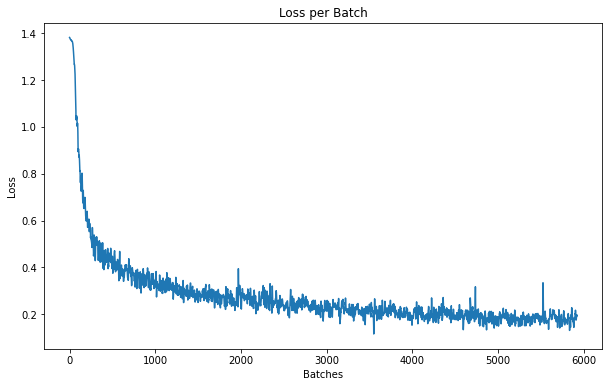

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_time , np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

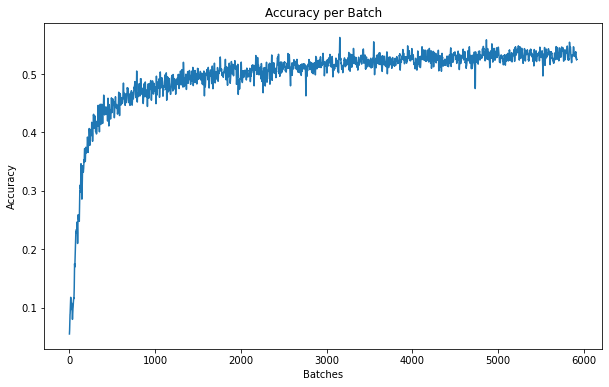

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_time , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model_test_acc_time = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_time.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_time))

average Test Accuracy:  0.8694711538461538


### Comparison

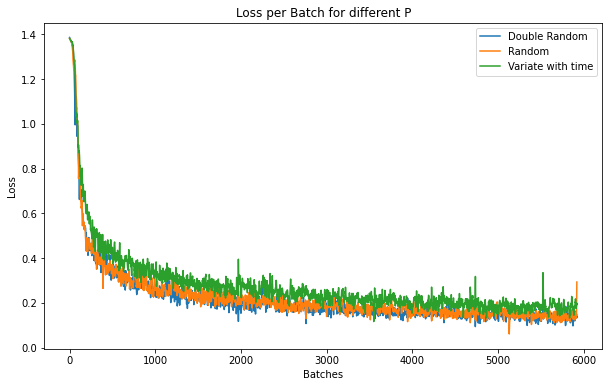

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train , np.ones(5)/5, mode='valid'), label='Double Random')
plt.plot(np.convolve(losses_train_random , np.ones(5)/5, mode='valid'), label='Random')
plt.plot(np.convolve(losses_train_time , np.ones(5)/5, mode='valid'), label='Variate with time')
plt.title('Loss per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

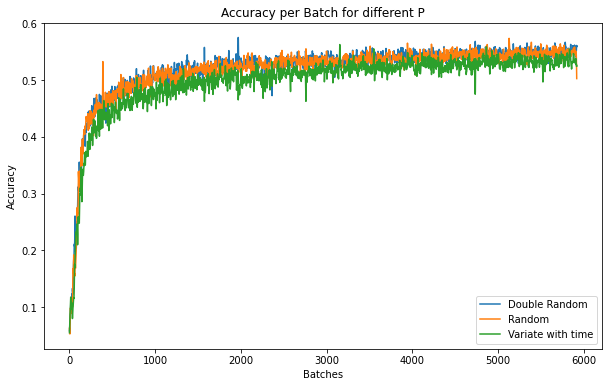

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train , np.ones(5)/5, mode='valid'), label='Double Random')
plt.plot(np.convolve(acc_train_random , np.ones(5)/5, mode='valid'), label='Random')
plt.plot(np.convolve(acc_train_time , np.ones(5)/5, mode='valid'), label='Variate with time')
plt.title('Accuracy per Batch for different P')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Add Delay in Communications

In [ ]:
def p2p_aggregate(first_model, second_model, first_weight, second_weight, delay =False, first_state_dict=None, second_state_dict=None):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    if  not delay:
      global_dict = first_model.state_dict()
      for k in global_dict.keys():
        first = first_model.state_dict()[k] * (first_weight) / (first_weight + second_weight)
        second = second_model.state_dict()[k] * (second_weight) / (first_weight + second_weight)
        sum_2 = first.add(second)
        global_dict[k] =  sum_2
      first_model.load_state_dict(global_dict)
      #second_model.load_state_dict(global_dict)
    else:
      global_dict = first_state_dict
      for k in first_state_dict.keys():
        first = first_state_dict[k] * (first_weight) / (first_weight + second_weight)
        second = second_state_dict[k] * (second_weight) / (first_weight + second_weight)
        sum_2 = first.add(second)
        global_dict[k] =  sum_2
      first_model.load_state_dict(global_dict)
      #second_model.load_state_dict(global_dict)



In [ ]:
def process_messages( queue, reciver, constant = False):
  for sender in list(queue.keys()):
    if 'not delay' in queue[sender] and len(queue[sender]) == 1:
      weight_i = communication_matrix[reciver][reciver]
      weight_j = communication_matrix[reciver][int(sender)]
      p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j)
      if not constant:
        communication_matrix[reciver][reciver] += weight_j
      del queue[sender]
    elif 'delay' in queue[sender]:
      delay_index = queue[sender].index('delay')
      queue[sender][delay_index] = 'not delay'

    elif 'not delay' in queue[sender] and len(queue[sender]) == 2:
      weight_i = communication_matrix[reciver][reciver]
      weight_j = communication_matrix[reciver][int(sender)]
      p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j, delay=True , first_state_dict = client_models[reciver].state_dict(), second_state_dict=queue[sender][0])
      if not constant:
        communication_matrix[reciver][reciver] += weight_j 
      del queue[sender]
      

In [ ]:
def push_message(sender, reciver, constant=False, delay = False):
  if not constant:
    communication_matrix[reciver][sender] /= 2
  if not delay:
    queue[reciver][str(sender)] = ['not delay']
  else:
    queue[reciver][str(sender)] = [client_models[sender].state_dict(), 'delay']

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

criterion = nn.CrossEntropyLoss()

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_time = []
acc_train_time = []
val_losses_time = []
val_accs_time = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i, False)
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            if np.random.binomial( n=1, p = 0.5):
              push_message( second_agent_index, i, False, True)
              #print('delay occured!!!')
            else :
              push_message( second_agent_index, i, False)
        except StopIteration:
          pass
        losses_train_time.append(loss/num_clients)
        acc_train_time.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_time.append(val_accuracy)
    val_losses_time.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_time[-1]} - average train accuracy {acc_train_time[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.7863991320133209 - average train accuracy 0.7375 - epoch validation loss 0.7232948797635543 - epoch validation accuracy 0.7483173076923078


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


average train loss 0.3874725103378296 - average train accuracy 0.825 - epoch validation loss 0.5227684518465628 - epoch validation accuracy 0.8180889423076924


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


average train loss 0.46788984537124634 - average train accuracy 0.8375 - epoch validation loss 0.48222754813539687 - epoch validation accuracy 0.8357371794871795


100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


average train loss 0.43688733875751495 - average train accuracy 0.825 - epoch validation loss 0.4421755511982319 - epoch validation accuracy 0.8536658653846153


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.3654393911361694 - average train accuracy 0.8625 - epoch validation loss 0.4121988921975478 - epoch validation accuracy 0.8646233974358974


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


average train loss 0.572454085946083 - average train accuracy 0.875 - epoch validation loss 0.40685523331929485 - epoch validation accuracy 0.8644030448717949


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.45154120922088625 - average train accuracy 0.8625 - epoch validation loss 0.44184773445893566 - epoch validation accuracy 0.8547676282051283


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


average train loss 0.6469049394130707 - average train accuracy 0.775 - epoch validation loss 0.41265593962027475 - epoch validation accuracy 0.8641626602564102


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


average train loss 0.278350044041872 - average train accuracy 0.925 - epoch validation loss 0.40328852862883835 - epoch validation accuracy 0.8724759615384615


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


average train loss 0.3426717847585678 - average train accuracy 0.9125 - epoch validation loss 0.39020341693972926 - epoch validation accuracy 0.8748998397435898


100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


average train loss 0.2606501251459122 - average train accuracy 0.925 - epoch validation loss 0.38539432455331857 - epoch validation accuracy 0.876181891025641


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


average train loss 0.297162863612175 - average train accuracy 0.85 - epoch validation loss 0.3889886831339353 - epoch validation accuracy 0.877403846153846


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


average train loss 0.2660286381840706 - average train accuracy 0.875 - epoch validation loss 0.40875043108677256 - epoch validation accuracy 0.8728165064102564


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


average train loss 0.23268541172146798 - average train accuracy 0.9375 - epoch validation loss 0.40442569303588993 - epoch validation accuracy 0.878165064102564


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


average train loss 0.3792703241109848 - average train accuracy 0.85 - epoch validation loss 0.38698407363815185 - epoch validation accuracy 0.8835737179487181


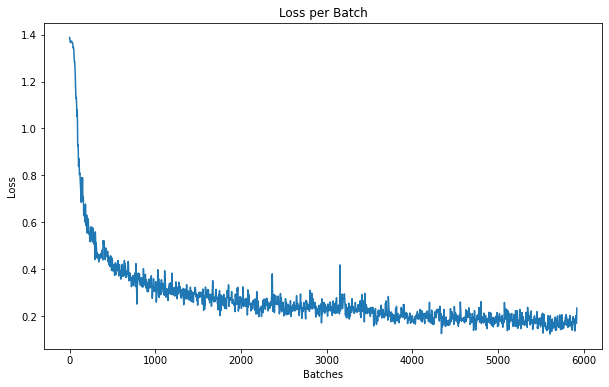

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_time, np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

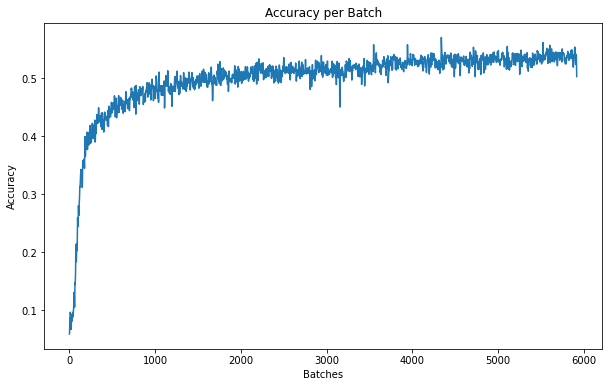

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_time , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model_test_acc_time = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_time.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_time))

average Test Accuracy:  0.8730568910256409


## Add Noise in Communications

In [ ]:
def p2p_aggregate(first_model, second_model, first_weight, second_weight):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = first_model.state_dict()
    for k in global_dict.keys():
      first = (first_model.state_dict()[k] * (first_weight) / (first_weight + second_weight)) + np.random.normal(loc=0, scale=0.01)
      second = (second_model.state_dict()[k] * (second_weight) / (first_weight + second_weight)) + np.random.normal(loc=0, scale=0.01)
      sum_2 = first.add(second)
      global_dict[k] =  sum_2
    first_model.load_state_dict(global_dict)
    #second_model.load_state_dict(global_dict)

In [ ]:
def process_messages( queue, reciver):
  
  for sender in queue.keys():
    weight_i = communication_matrix[reciver][reciver]
    weight_j = communication_matrix[reciver][queue[sender]]
    p2p_aggregate(client_models[reciver], client_models[int(sender)], weight_i, weight_j)
    communication_matrix[reciver][reciver] += weight_j
    
  

In [ ]:
def push_message(sender, reciver):
  communication_matrix[reciver][sender] /= 2
  queue[reciver][str(sender)] = sender

In [ ]:
# Dividing the training data into num_clients, with each client having equal number of images
train,valid = torch.utils.data.random_split(train_set, [50000,10000])

traindata_split = torch.utils.data.random_split(train, [int(len(train) / num_clients) for _ in range(num_clients)])
train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]

validloader = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [ ]:
############## client models ##############
client_models = [ Network().to(device) for _ in range(num_clients)] 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay= 0.0001) for model in client_models]

############### Queues ################

queue = [{} for i in range(num_clients)]

criterion = nn.CrossEntropyLoss()

In [ ]:
communication_matrix = np.ones((num_clients, num_clients)) / num_clients

In [ ]:
losses_train_noise = []
acc_train_noise = []
val_losses_noise = []
val_accs_noise = []
for r in range(15):
    for j in tqdm(range(len(train_loader[0]))):
      loss = 0
      acc = 0
      for i in range(num_clients):
        try:
          data  = next(train_loader[i])
          process_messages( queue[i],i)
          local_loss, local_acc= client_update(client_models[i], opt[i], data)
          loss += local_loss
          acc += local_acc
          if np.random.binomial( n=1, p = 0.5):
            j_weights = communication_matrix[i]
            second_agent_index = second_agent(i, j_weights)
            push_message( second_agent_index, i)
        except StopIteration:
          pass
        losses_train_noise.append(loss/num_clients)
        acc_train_noise.append(acc/num_clients)
    val_loss, val_accuracy = validation(client_models, validloader)
    val_accs_noise.append(val_accuracy)
    val_losses_noise.append(val_loss)
    train_loader = [iter(torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True)) for x in traindata_split]
    print(f'average train loss {losses_train_noise[-1]} - average train accuracy {acc_train_noise[-1]} - epoch validation loss {val_loss} - epoch validation accuracy {val_accuracy}' )

100%|██████████| 79/79 [00:24<00:00,  3.24it/s]


average train loss nan - average train accuracy 0.075 - epoch validation loss nan - epoch validation accuracy 0.10048076923076923


100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


average train loss nan - average train accuracy 0.0625 - epoch validation loss nan - epoch validation accuracy 0.10034054487179486


100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


average train loss nan - average train accuracy 0.0875 - epoch validation loss nan - epoch validation accuracy 0.1002003205128205


100%|██████████| 79/79 [00:24<00:00,  3.21it/s]


average train loss nan - average train accuracy 0.0875 - epoch validation loss nan - epoch validation accuracy 0.1002003205128205


100%|██████████| 79/79 [00:24<00:00,  3.20it/s]


average train loss nan - average train accuracy 0.05 - epoch validation loss nan - epoch validation accuracy 0.10034054487179486


100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


average train loss nan - average train accuracy 0.075 - epoch validation loss nan - epoch validation accuracy 0.10062099358974357


100%|██████████| 79/79 [00:24<00:00,  3.21it/s]


average train loss nan - average train accuracy 0.075 - epoch validation loss nan - epoch validation accuracy 0.10034054487179486


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


average train loss nan - average train accuracy 0.1375 - epoch validation loss nan - epoch validation accuracy 0.10104166666666667


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


average train loss nan - average train accuracy 0.1 - epoch validation loss nan - epoch validation accuracy 0.10048076923076923


100%|██████████| 79/79 [00:24<00:00,  3.25it/s]


average train loss nan - average train accuracy 0.075 - epoch validation loss nan - epoch validation accuracy 0.10076121794871795


100%|██████████| 79/79 [00:24<00:00,  3.26it/s]


average train loss nan - average train accuracy 0.0625 - epoch validation loss nan - epoch validation accuracy 0.10048076923076923


100%|██████████| 79/79 [00:24<00:00,  3.26it/s]


average train loss nan - average train accuracy 0.1375 - epoch validation loss nan - epoch validation accuracy 0.1006209935897436


100%|██████████| 79/79 [00:24<00:00,  3.26it/s]


average train loss nan - average train accuracy 0.1 - epoch validation loss nan - epoch validation accuracy 0.10034054487179486


100%|██████████| 79/79 [00:24<00:00,  3.24it/s]


average train loss nan - average train accuracy 0.075 - epoch validation loss nan - epoch validation accuracy 0.1002003205128205


100%|██████████| 79/79 [00:24<00:00,  3.25it/s]


average train loss nan - average train accuracy 0.0625 - epoch validation loss nan - epoch validation accuracy 0.1006209935897436


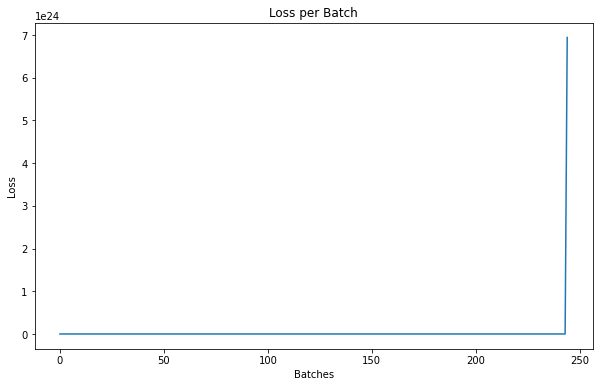

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(losses_train_noise, np.ones(5)/5, mode='valid'))
plt.title('Loss per Batch')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

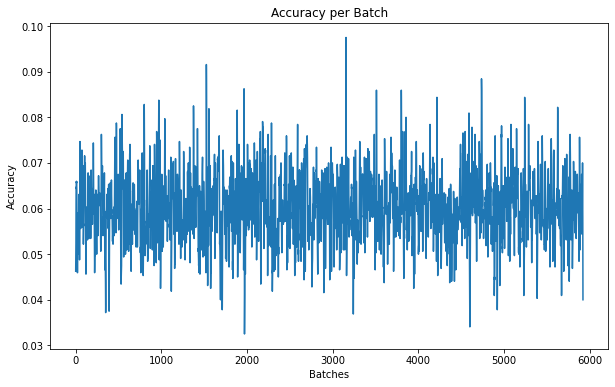

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.convolve(acc_train_noise , np.ones(5)/5, mode='valid'))
plt.title('Accuracy per Batch')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model_test_acc_noise = []
for i in range(len(client_models)):
  model = client_models[i]
  model.eval()
  with torch.no_grad():
    val_acc = 0
    for j, data in enumerate(testloader):
          
      image = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients.
      # Feed forward
      output = model(image)
      preds = torch.argmax(output, axis=1)
      v_acc = torch.sum(preds == labels) / len(labels)
      # Calculate the batch loss.
      loss = criterion(output , labels)
      val_acc += v_acc.item()
  model_test_acc_noise.append(val_acc/j)
print('average Test Accuracy: ', np.mean(model_test_acc_noise))

average Test Accuracy:  0.10114182692307691
